# Benchmark model: Holt Winters

## Preperation 

In [1]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

from own_functions import train_test_timesplit

import warnings
warnings.filterwarnings('ignore')

In [2]:
# function for evaluation of models
def model_classification(actual, predicted): 
    """
    Prints out RSME, MAE and explained variance score
    """
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [3]:
def log_cases(df):
    df = df.assign(logged_cases = lambda df: np.log(df['total_cases']+1))
    return df

In [4]:
# load data
data_subsets = pickle.load(open('cleaned_data.pickle', 'rb'))

# Splitting the data into their parts
sj_features_train, \
sj_features_test, \
sj_labels_train, \
iq_features_train, \
iq_features_test, \
iq_labels_train = data_subsets

In [5]:
# set dictionary to access colors
colors= {'actual_weekly':'#a2bffe',
         'actual_monthly':'#26538d',
         'predicted_weekly':'coral',
         'predicted_monthly':'sienna'}

In [6]:
# get log of cases as column
sj_train = log_cases(sj_labels_train)
iq_train = log_cases(iq_labels_train)

# cut off first years of iq dataset (only singular cases; probably different counting of cases)
iq_train = iq_train['2002':]

# get another dataset with monthly fequency (number of cases per month = SUM)
sj_train_month = sj_train[['total_cases']].resample('M').sum()
iq_train_month = iq_train[['total_cases']].resample('M').sum()
sj_train_month = log_cases(sj_train_month)
iq_train_month = log_cases(iq_train_month)

# split dataframe into train and test dataset
sj_train_train, sj_train_test = train_test_timesplit(sj_train) 
iq_train_train, iq_train_test = train_test_timesplit(iq_train)

sj_train_train_month, sj_train_test_month = train_test_timesplit(sj_train_month) 
iq_train_train_month, iq_train_test_month = train_test_timesplit(iq_train_month)

print(20*'--')
print(f'San Juan ratio between test / train datasets: {round((sj_features_train.shape[0]/(sj_features_train.shape[0]+sj_features_test.shape[0])),2)}')
print(f'Iquitos ratio between test / train datasets: {round((iq_features_train.shape[0]/(iq_features_train.shape[0]+iq_features_test.shape[0])),2)}')
print(20*'--')
print(f'San Juan train_train: {sj_train_train.shape[0]} which is {round((sj_train_train.shape[0]/sj_train.shape[0])*100,1)} %')
print(f'San Juan train_test: {sj_train_test.shape[0]} which is {round((sj_train_test.shape[0]/sj_train.shape[0])*100,1)} %')
print(20*'--')
print(f'Iquitos train_train: {iq_train_train.shape[0]} which is {round((iq_train_train.shape[0]/iq_train.shape[0])*100,1)} %')
print(f'Iquitos train_test: {iq_train_test.shape[0]} which is {round((iq_train_test.shape[0]/iq_train.shape[0])*100,1)} %')
print(20*'--')

----------------------------------------
San Juan ratio between test / train datasets: 0.78
Iquitos ratio between test / train datasets: 0.77
----------------------------------------
San Juan train_train: 703 which is 75.1 %
San Juan train_test: 233 which is 24.9 %
----------------------------------------
Iquitos train_train: 332 which is 75.1 %
Iquitos train_test: 110 which is 24.9 %
----------------------------------------


## Model: Holt Winters Exponential Smoothing
---
### San Juan - weekly data

In [16]:
# HWES on non-transformed cases
sj_expo = ExponentialSmoothing(sj_train_train.total_cases, 
                               trend=None, 
                               seasonal='add', 
                               seasonal_periods=52)
sj_expo_fit = sj_expo.fit() 

# forecasting test data
sj_pred_test = sj_expo_fit.forecast(steps=len(sj_train_test.total_cases)).clip(lower=0)

# in-sample prediction on train data
sj_pred_train = sj_expo_fit.predict(0, len(sj_train_train)).clip(lower=0)

In [21]:
# HWES with logged cases
sj_expo_log = ExponentialSmoothing(sj_train_train.logged_cases, 
                               trend=None, 
                               seasonal='add', 
                               seasonal_periods=52)
sj_expo_fit_log = sj_expo_log.fit() 

# forecasting test data
sj_pred_test_log = sj_expo_fit_log.forecast(steps=len(sj_train_test.logged_cases)).clip(lower=0)

# in-sample prediction on train data
sj_pred_train_log = sj_expo_fit_log.predict(0, len(sj_train_train)).clip(lower=0)

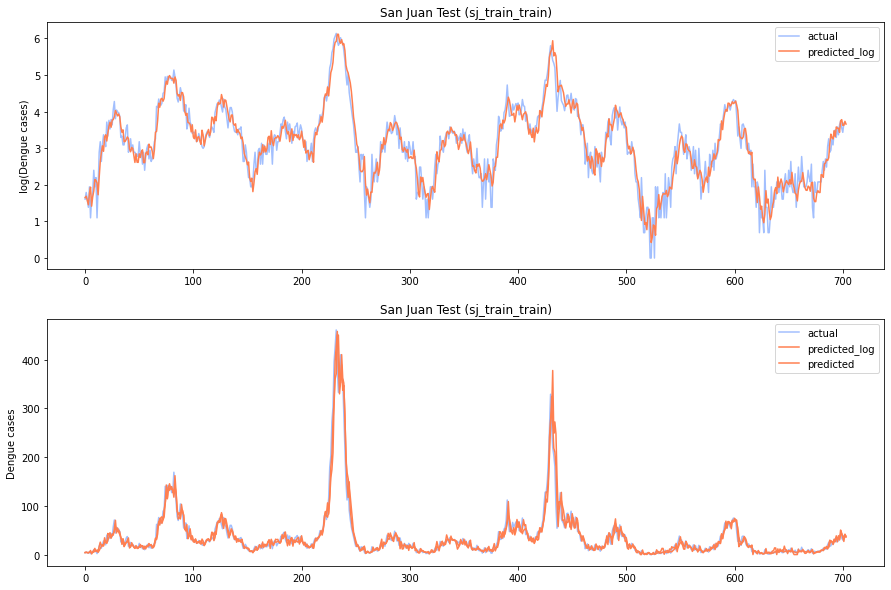

In [18]:
# plot predicted log cases for SJ train_tain
fig, ax = plt.subplots(2, 1, figsize=(15,10))

sj_train_train.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_weekly'])
sj_pred_train_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_weekly']);

ax[0].legend(labels=['actual', 'predicted_log'])
ax[0].set(title='San Juan Test (sj_train_train)', ylabel='log(Dengue cases)');

sj_train_train.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_weekly'])
(np.exp(sj_pred_train_log)-1).reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly']);
sj_pred_train.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly']);

ax[1].legend(labels=['actual', 'predicted_log', 'predicted'])
ax[1].set(title='San Juan Test (sj_train_train)', ylabel='Dengue cases');

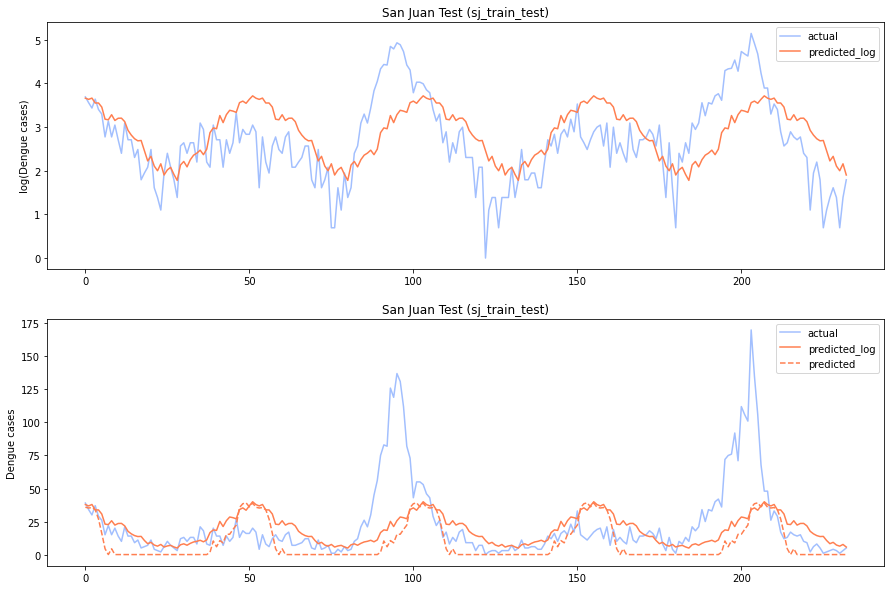

In [20]:
# plot predicted log cases for SJ train_test
fig, ax = plt.subplots(2, 1, figsize=(15,10))

sj_train_test.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_weekly'])
sj_pred_test_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_weekly']);

ax[0].legend(labels=['actual', 'predicted_log'])
ax[0].set(title='San Juan Test (sj_train_test)', ylabel='log(Dengue cases)');

sj_train_test.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_weekly'])
(np.exp(sj_pred_test_log)-1).reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly']);
sj_pred_test.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly'], ls='--');

ax[1].legend(labels=['actual', 'predicted_log', 'predicted'])
ax[1].set(title='San Juan Test (sj_train_test)', ylabel='Dengue cases');

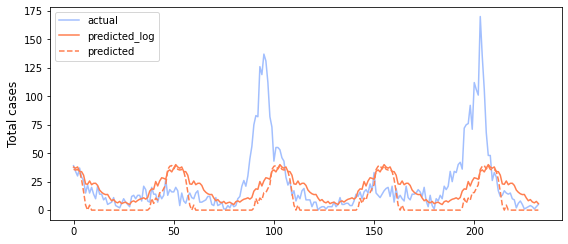

In [22]:
fig, ax = plt.subplots(figsize=(8,3.5))

sj_train_test.reset_index().total_cases.plot(ax=ax, color=colors['actual_weekly'])
(np.exp(sj_pred_test_log)-1).reset_index(drop=True).plot(ax=ax, color=colors['predicted_weekly']);
sj_pred_test.reset_index(drop=True).plot(ax=ax, color=colors['predicted_weekly'], ls='--');

ax.legend(labels=['actual', 'predicted_log', 'predicted'], loc=0)
ax.set_ylabel('Total cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('plots/SJ_holt_winters.png', dpi=200)

In [56]:
# evaluation for log-transformed 
model_classification(sj_train_test.total_cases, np.exp(sj_pred_test_log)-1)

--------------------
RMSE: 26.65
--------------------
MAE: 15.42
Explained variance: 0.145
--------------------


In [57]:
# evaluation for non-transformed 
model_classification(sj_train_test.total_cases, sj_pred_test)

--------------------
RMSE: 29.68
--------------------
MAE: 17.77
Explained variance: 0.141
--------------------


---
### San Juan - monthly data

In [30]:
# HWES on non-transformed cases
sj_expo_month = ExponentialSmoothing(sj_train_train_month.total_cases, 
                                     trend=None, 
                                     seasonal='add', 
                                     seasonal_periods=12)
sj_expo_month_fit = sj_expo_month.fit() 

# forecasting test data
sj_pred_test_month = sj_expo_month_fit.forecast(steps=len(sj_train_test_month.total_cases)).clip(lower=0)

# in-sample prediction on train data
sj_pred_train_month = sj_expo_month_fit.predict(0, len(sj_train_train_month)).clip(lower=0)

In [31]:
# HWES with logged cases
sj_expo_month_log = ExponentialSmoothing(sj_train_train_month.logged_cases, 
                                         trend=None, 
                                         seasonal='add', 
                                         seasonal_periods=12)
sj_expo_month_fit_log = sj_expo_month_log.fit() 

# forecasting test data
sj_pred_test_month_log = sj_expo_month_fit_log.forecast(steps=len(sj_train_test_month.logged_cases)).clip(lower=0)

# in-sample prediction on train data
sj_pred_train_month_log = sj_expo_month_fit_log.predict(0, len(sj_train_train_month)).clip(lower=0)

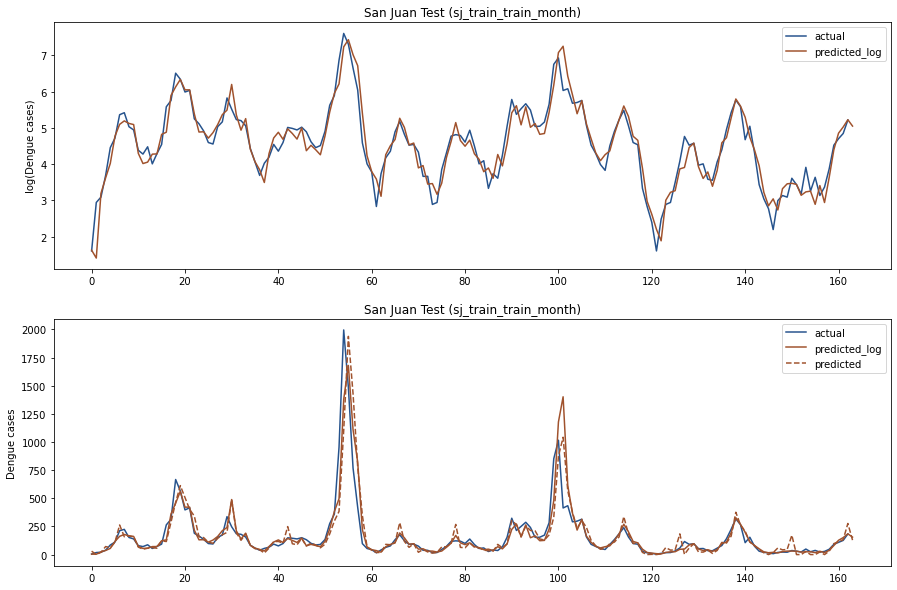

In [32]:
# plot predicted log cases for SJ train_tain_monthly
fig, ax = plt.subplots(2, 1, figsize=(15,10))

sj_train_train_month.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_monthly'])
sj_pred_train_month_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_monthly']);

ax[0].legend(labels=['actual', 'predicted_log'])
ax[0].set(title='San Juan Test (sj_train_train_month)', ylabel='log(Dengue cases)');

sj_train_train_month.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_monthly'])
(np.exp(sj_pred_train_month_log)-1).reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_monthly']);
sj_pred_train_month.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_monthly'], ls='--');

ax[1].legend(labels=['actual', 'predicted_log', 'predicted'])
ax[1].set(title='San Juan Test (sj_train_train_month)', ylabel='Dengue cases');

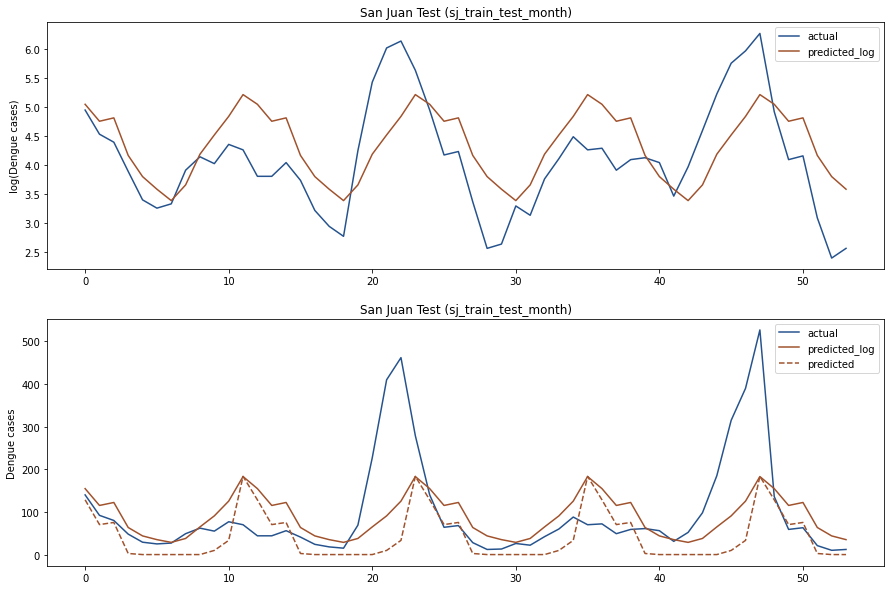

In [33]:
# plot predicted log cases for SJ train_test
fig, ax = plt.subplots(2, 1, figsize=(15,10))

sj_train_test_month.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_monthly'])
sj_pred_test_month_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_monthly']);

ax[0].legend(labels=['actual', 'predicted_log'])
ax[0].set(title='San Juan Test (sj_train_test_month)', ylabel='log(Dengue cases)');

sj_train_test_month.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_monthly'])
(np.exp(sj_pred_test_month_log)-1).reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_monthly']);
sj_pred_test_month.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_monthly'], ls='--');

ax[1].legend(labels=['actual', 'predicted_log', 'predicted'])
ax[1].set(title='San Juan Test (sj_train_test_month)', ylabel='Dengue cases');

In [34]:
# evaluation for log-transformed 
model_classification(sj_train_test_month.total_cases, np.exp(sj_pred_test_month_log)-1)

--------------------
RMSE: 105.58
--------------------
MAE: 65.42
Explained variance: 0.192
--------------------


In [35]:
# evaluation for non-transformed 
model_classification(sj_train_test_month.total_cases, sj_pred_test_month)

--------------------
RMSE: 126.79
--------------------
MAE: 73.34
Explained variance: 0.049
--------------------


---
### Iquitos - weekly data

In [43]:
# HWES on non-transformed cases
iq_expo = ExponentialSmoothing(iq_train_train.total_cases, 
                               trend=None, 
                               seasonal='add', 
                               seasonal_periods=52)
iq_expo_fit = iq_expo.fit() 

# forecasting test data
iq_pred_test = iq_expo_fit.forecast(steps=len(iq_train_test.total_cases)).clip(lower=0)

# in-sample prediction on train data
iq_pred_train = iq_expo_fit.predict(0, len(iq_train_train)).clip(lower=0)

In [44]:
# HWES with logged cases
iq_expo_log = ExponentialSmoothing(iq_train_train.logged_cases, 
                               trend=None, 
                               seasonal='add', 
                               seasonal_periods=52)
iq_expo_fit_log = iq_expo_log.fit() 

# forecasting test data
iq_pred_test_log = iq_expo_fit_log.forecast(steps=len(iq_train_test.logged_cases)).clip(lower=0)

# in-sample prediction on train data
iq_pred_train_log = iq_expo_fit_log.predict(0, len(iq_train_train)).clip(lower=0)

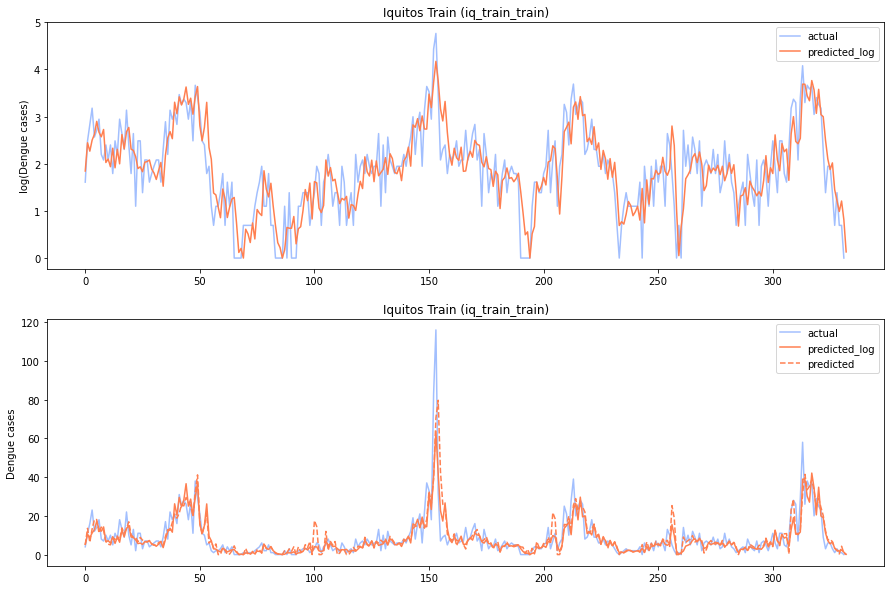

In [45]:
# plot predicted log cases for iq train_tain
fig, ax = plt.subplots(2, 1, figsize=(15,10))

iq_train_train.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_weekly'])
iq_pred_train_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_weekly']);

ax[0].legend(labels=['actual', 'predicted_log'])
ax[0].set(title='Iquitos Train (iq_train_train)', ylabel='log(Dengue cases)');

iq_train_train.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_weekly'])
(np.exp(iq_pred_train_log)-1).reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly']);
iq_pred_train.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly'], ls='--');

ax[1].legend(labels=['actual', 'predicted_log', 'predicted'])
ax[1].set(title='Iquitos Train (iq_train_train)', ylabel='Dengue cases');

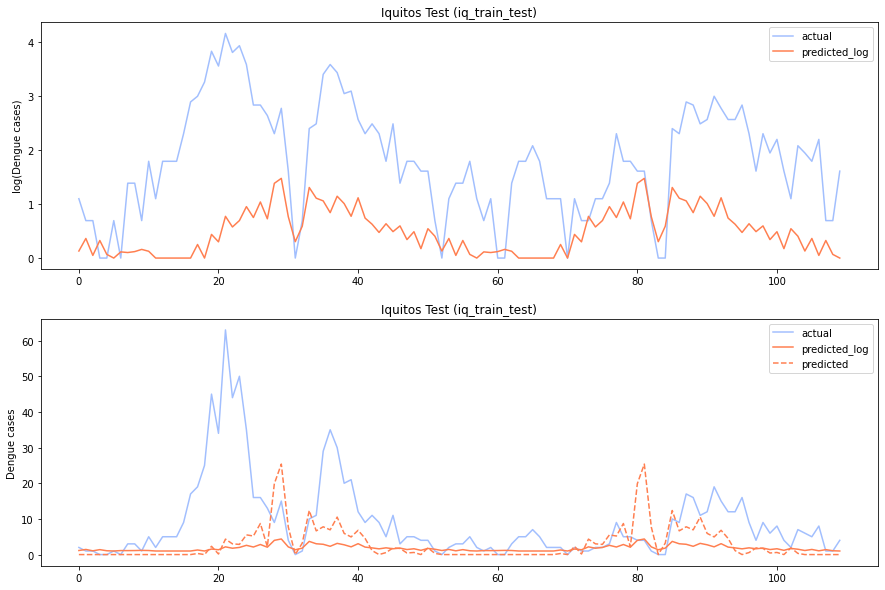

In [46]:
# plot predicted log cases for iq train_test
fig, ax = plt.subplots(2, 1, figsize=(15,10))

iq_train_test.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_weekly'])
iq_pred_test_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_weekly']);

ax[0].legend(labels=['actual', 'predicted_log'])
ax[0].set(title='Iquitos Test (iq_train_test)', ylabel='log(Dengue cases)');

iq_train_test.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_weekly'])
np.exp(iq_pred_test_log.reset_index(drop=True)).plot(ax=ax[1], color=colors['predicted_weekly']);
iq_pred_test.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly'], ls='--');

ax[1].legend(labels=['actual', 'predicted_log', 'predicted'])
ax[1].set(title='Iquitos Test (iq_train_test)', ylabel='Dengue cases');

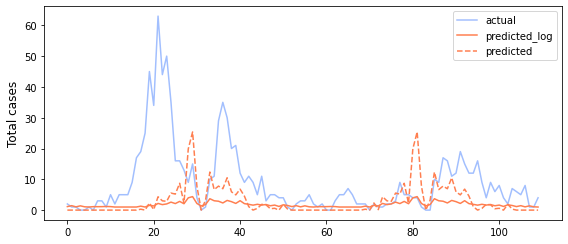

In [47]:
fig, ax = plt.subplots(figsize=(8,3.5))

iq_train_test.reset_index().total_cases.plot(ax=ax, color=colors['actual_weekly'])
np.exp(iq_pred_test_log.reset_index(drop=True)).plot(ax=ax, color=colors['predicted_weekly']);
iq_pred_test.reset_index(drop=True).plot(ax=ax, color=colors['predicted_weekly'], ls='--');

ax.legend(labels=['actual', 'predicted_log', 'predicted'], loc=0)
ax.set_ylabel('Total cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('plots/IQ_holt_winters.png', dpi=200)

In [48]:
# evaluation for log-transformed 
model_classification(iq_train_test.total_cases, np.exp(iq_pred_test_log)-1)

--------------------
RMSE: 13.81
--------------------
MAE: 8.31
Explained variance: 0.037
--------------------


In [49]:
# evaluation for non-transformed 
model_classification(iq_train_test.total_cases, iq_pred_test)

--------------------
RMSE: 12.8
--------------------
MAE: 7.68
Explained variance: -0.002
--------------------


---
### Iquitos - monthly data

In [50]:
# HWES on non-transformed cases
iq_expo_month = ExponentialSmoothing(iq_train_train_month.total_cases, 
                                     trend=None, 
                                     seasonal='add', 
                                     seasonal_periods=12)
iq_expo_month_fit = iq_expo_month.fit() 

# forecasting test data
iq_pred_test_month = iq_expo_month_fit.forecast(steps=len(iq_train_test_month.total_cases)).clip(lower=0)

# in-sample prediction on train data
iq_pred_train_month = iq_expo_month_fit.predict(0, len(iq_train_train_month)).clip(lower=0)

In [51]:
# HWES with logged cases
iq_expo_month_log = ExponentialSmoothing(iq_train_train_month.logged_cases, 
                                         trend=None, 
                                         seasonal='add', 
                                         seasonal_periods=12)
iq_expo_month_fit_log = iq_expo_month_log.fit() 

# forecasting test data
iq_pred_test_month_log = iq_expo_month_fit_log.forecast(steps=len(iq_train_test_month.logged_cases)).clip(lower=0)

# in-sample prediction on train data
iq_pred_train_month_log = iq_expo_month_fit_log.predict(0, len(iq_train_train_month)).clip(lower=0)

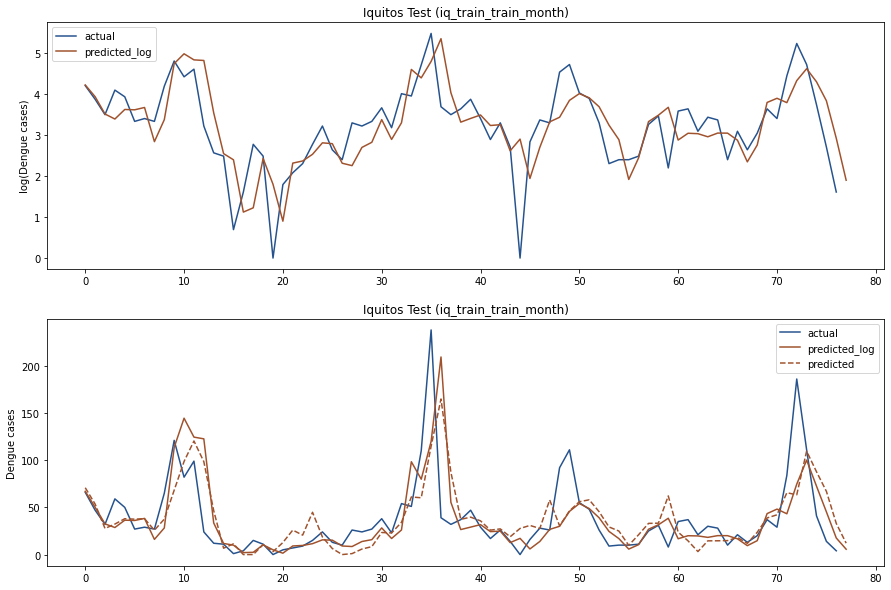

In [52]:
# plot predicted log cases for iq train_tain_monthly
fig, ax = plt.subplots(2, 1, figsize=(15,10))

iq_train_train_month.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_monthly'])
iq_pred_train_month_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_monthly']);

ax[0].legend(labels=['actual', 'predicted_log'])
ax[0].set(title='Iquitos Test (iq_train_train_month)', ylabel='log(Dengue cases)');

iq_train_train_month.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_monthly'])
(np.exp(iq_pred_train_month_log)-1).reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_monthly']);
iq_pred_train_month.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_monthly'], ls='--');

ax[1].legend(labels=['actual', 'predicted_log', 'predicted'])
ax[1].set(title='Iquitos Test (iq_train_train_month)', ylabel='Dengue cases');

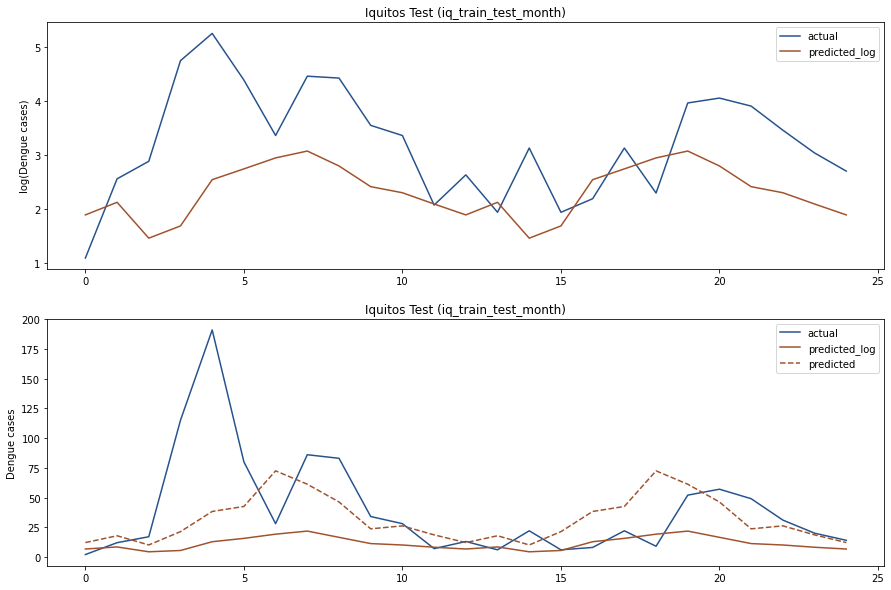

In [53]:
# plot predicted log cases for iq train_test
fig, ax = plt.subplots(2, 1, figsize=(15,10))

iq_train_test_month.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_monthly'])
iq_pred_test_month_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_monthly']);

ax[0].legend(labels=['actual', 'predicted_log'])
ax[0].set(title='Iquitos Test (iq_train_test_month)', ylabel='log(Dengue cases)');

iq_train_test_month.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_monthly'])
np.exp(iq_pred_test_month_log.reset_index(drop=True)).plot(ax=ax[1], color=colors['predicted_monthly']);
iq_pred_test_month.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_monthly'], ls='--');

ax[1].legend(labels=['actual', 'predicted_log', 'predicted'])
ax[1].set(title='Iquitos Test (iq_train_test_month)', ylabel='Dengue cases');

In [54]:
# evaluation for log-transformed 
model_classification(iq_train_test_month.total_cases, np.exp(iq_pred_test_month_log)-1)

--------------------
RMSE: 50.65
--------------------
MAE: 30.66
Explained variance: 0.059
--------------------


In [55]:
# evaluation for non-transformed 
model_classification(iq_train_test_month.total_cases, iq_pred_test_month)

--------------------
RMSE: 42.25
--------------------
MAE: 25.77
Explained variance: 0.054
--------------------
